In [ ]:
import copy
import geopy.distance
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
matplotlib.rcParams.update({'font.size': 13})

# Read Data

In [ ]:
# Read csv data
url = 'https://github.com/hflabs/city/blob/master/city.csv?raw=true'
df = pd.read_csv(url)
df.head(5)

address  postal_code country federal_district region_type  \
0   Респ Адыгея, г Адыгейск     385200.0  Россия            Южный        Респ   
1                  г Майкоп     385000.0  Россия            Южный        Респ   
2           г Горно-Алтайск     649000.0  Россия        Сибирский        Респ   
3  Алтайский край, г Алейск     658125.0  Россия        Сибирский        край   
4                 г Барнаул     656000.0  Россия        Сибирский        край   

      region area_type area city_type           city  ... fias_level  \
0     Адыгея       NaN  NaN         г       Адыгейск  ...          4   
1     Адыгея       NaN  NaN         г         Майкоп  ...          4   
2      Алтай       NaN  NaN         г  Горно-Алтайск  ...          4   
3  Алтайский       NaN  NaN         г         Алейск  ...          4   
4  Алтайский       NaN  NaN         г        Барнаул  ...          4   

  capital_marker        okato        oktmo  tax_office  timezone    geo_lat  \
0              0  79403000000  79703000001         107     UTC+3  44.878414   
1              2  79401000000  79701000001         105     UTC+3  44.609827   
2              2  84401000000  84701000001         400     UTC+7  51.958103   
3              0   1403000000   1703000001        2201     UTC+7  52.492251   
4              2   1401000000   1701000001        2200     UTC+7  53.347997   

     geo_lon  population foundation_year  
0  39.190289       12689            1969  
1  40.100661      144055            1857  
2  85.960324       62861            1830  
3  82.779361       28528            1913  
4  83.779806      635585            1730  

[5 rows x 24 columns]

In [ ]:
# Extract 30 most populated cities
df.city.fillna(df.address, inplace=True)
df = df.sort_values(by=['population'], ascending=False)
df2 = df.iloc[:30, :].loc[:,["city", "geo_lat","geo_lon"]]
data = df2.to_dict('records')
data

[{'city': 'г Москва', 'geo_lat': 55.7540471, 'geo_lon': 37.620405},
 {'city': 'г Санкт-Петербург', 'geo_lat': 59.9391313, 'geo_lon': 30.3159004},
 {'city': 'Новосибирск', 'geo_lat': 55.028191, 'geo_lon': 82.9211489},
 {'city': 'Екатеринбург', 'geo_lat': 56.8385216, 'geo_lon': 60.6054911},
 {'city': 'Нижний Новгород', 'geo_lat': 56.3240627, 'geo_lon': 44.0053913},
 {'city': 'Казань', 'geo_lat': 55.7943584, 'geo_lon': 49.1114975},
 {'city': 'Самара', 'geo_lat': 53.1950306, 'geo_lon': 50.1069518},
 {'city': 'Омск', 'geo_lat': 54.9848566, 'geo_lon': 73.3674517},
 {'city': 'Челябинск', 'geo_lat': 55.1602624, 'geo_lon': 61.4008078},
 {'city': 'Ростов-на-Дону', 'geo_lat': 47.2224566, 'geo_lon': 39.718803},
 {'city': 'Уфа', 'geo_lat': 54.734944, 'geo_lon': 55.9578468},
 {'city': 'Волгоград', 'geo_lat': 48.7070042, 'geo_lon': 44.5170339},
 {'city': 'Пермь', 'geo_lat': 58.0102583, 'geo_lon': 56.2342034},
 {'city': 'Красноярск', 'geo_lat': 56.0093879, 'geo_lon': 92.8524806},
 {'city': 'Воронеж', 

# Functions

In [ ]:
def find_distance(city1, city2):
    # Calculate distance between two cities
    coords_1 = (city1["geo_lat"], city1["geo_lon"])
    coords_2 = (city2["geo_lat"], city2["geo_lon"])
    return geopy.distance.geodesic(coords_1, coords_2).km

def create_path(cities):
    # Create a path from cities so that the last city was connected to the first one
    path = copy.copy(cities)
    path.append(cities[0])
    return path

def dist(cities):
    # Calculate the total distance
    path = create_path(cities)
    d = 0
    for i in range(1, len(path)):
        d+=find_distance(path[i-1], path[i])
    return d

def proposal_distribution(cities):
    # Swap to cities 
    i1, i2 = random.sample(range(len(cities)), 2)
    new_cities = copy.copy(cities)
    new_cities[i1], new_cities[i2] = new_cities[i2], new_cities[i1]
    return new_cities

def calculate_acceptance_ratio(x_new_dist, x_dist, T):
    try:
      return math.exp((x_dist-x_new_dist)/T)
    except:
      return 0

def show_solution(cities):
    x = list(map(lambda x:x["geo_lon"], cities))
    y = list(map(lambda x:x["geo_lat"], cities))
    names = list(map(lambda x:x["city"], cities))

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.scatter(x, y, color="r")
    ax.plot(x, y)

    for i, txt in enumerate(names[:-1]):
        ax.annotate(txt, (x[i], y[i]))

In [ ]:
def simulated_annealing(data, T=1000, N=100, min_T=1, annealing_rate=0.5, max_t=None):
    """
    T: initial temperature
    N: number of steps after which the temperature should be decreased
    min_T: minimum value for T to stop annealing
    annealing_rate: rate for scheduling
    max_t: maximum number of iterations 
    """
    random.shuffle(data)

    T_values = []
    T_history = []
    city_history = []
    dist_history = []

    x_t = data
    t = 1
    x_t_dist = dist(x_t)
    while T>min_T:
        T_values.append(T)
        x_t1 = proposal_distribution(x_t)
        x_t1_dist = dist(x_t1)

        acceptance_ratio = calculate_acceptance_ratio(x_t1_dist, x_t_dist, T)
        u = random.uniform(0, 1)
        if u <= acceptance_ratio:
            x_t = x_t1
            x_t_dist = x_t1_dist
            T_history.append(T)
            city_history.append(x_t)
            dist_history.append(x_t_dist)
        if t%N==0:
            T*=annealing_rate
        t+=1
        if max_t:
          if t==max_t:
              break
    return x_t, x_t_dist, T_values, [T_history, city_history, dist_history]

# Find optimal path

To find the optimal path we decided to use the slow cooling (annealing rate=0.99) and do not set the maximum number of iterations. Annealing should be stopped when the value of temperature reaches 1.  

In [ ]:
T = 1000
N = 30
min_T = 50

cities1, dist1, T_values1, history = simulated_annealing(data, T=T, min_T=1, N=50, annealing_rate=0.99)

Total distance: 18813.84 km


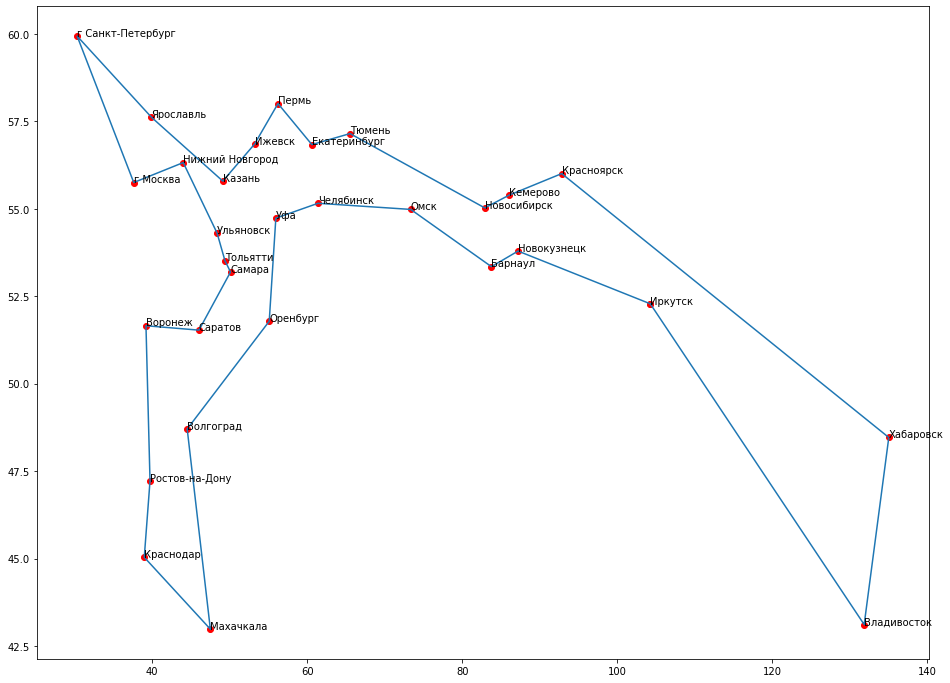

In [ ]:
print("Total distance: {:.2f} km".format(dist1))
show_solution(create_path(cities1))

# Compare the speed of convergence

We selected the annealing schedule with explonential decay and compared three colling processes with different anealing rate. For better visualization, we limitted the number of iterations by 5000. The temperature will be decreased every 100 steps for fast and middle cooling, and every 50 steps for fast colling. Initial temperature is 1000. 

In [ ]:
T = 1000
N = 100
max_t = 5000

# slow cooling
cities1, dist1, T_values1, history1 = simulated_annealing(data, T=T, N=N//2, annealing_rate=0.99, max_t=max_t)
# middle cooling
cities2, dist2, T_values2, history2 = simulated_annealing(data, T=T, N=N, annealing_rate=0.85, max_t=max_t)
# fast cooling
cities3, dist3, T_values3, history3 = simulated_annealing(data, T=T, N=N, annealing_rate=0.7, max_t=max_t)

In [ ]:
print("Slow cooling. Time: {:d}. Final distance: {:.2f} km".format(len(T_values1), dist1))
print("Middle cooling. Time: {:d}. Final distance: {:.2f} km".format(len(T_values2), dist2))
print("Fast cooling. Time: {:d}. Final distance: {:.2f} km".format(len(T_values3), dist3))

Slow cooling. Time: 4999. Final distance: 25210.90 km
Middle cooling. Time: 4300. Final distance: 21179.85 km
Fast cooling. Time: 2000. Final distance: 22165.77 km


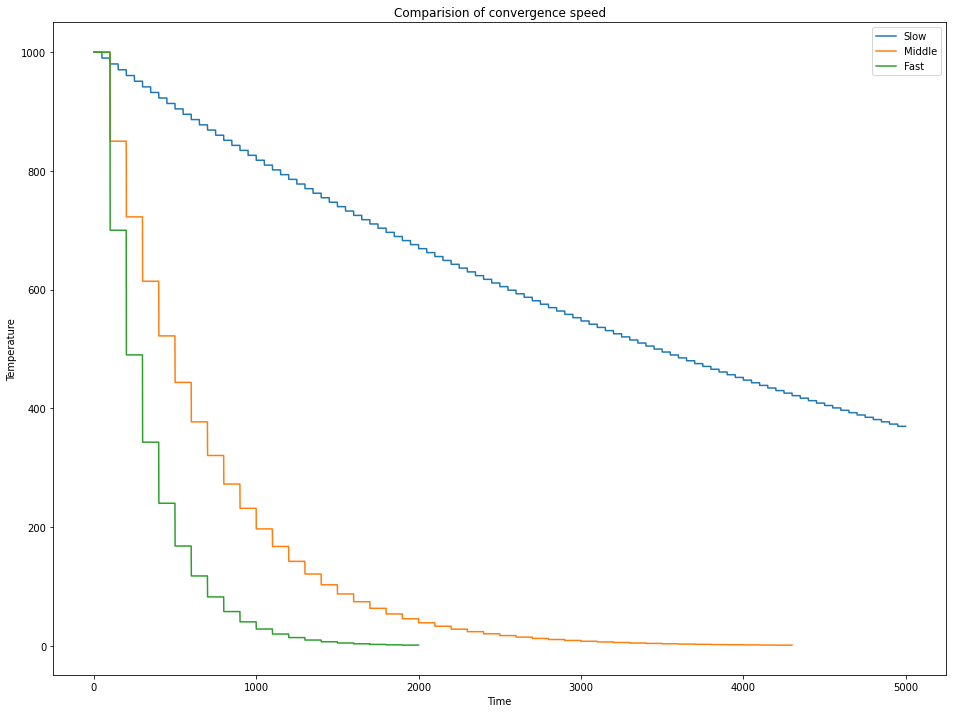

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(range(len(T_values1)), T_values1, label="Slow")
ax.plot(range(len(T_values2)), T_values2, label="Middle")
ax.plot(range(len(T_values3)), T_values3, label="Fast")

ax.set_title("Comparision of convergence speed")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature")
ax.legend()

# Visualization

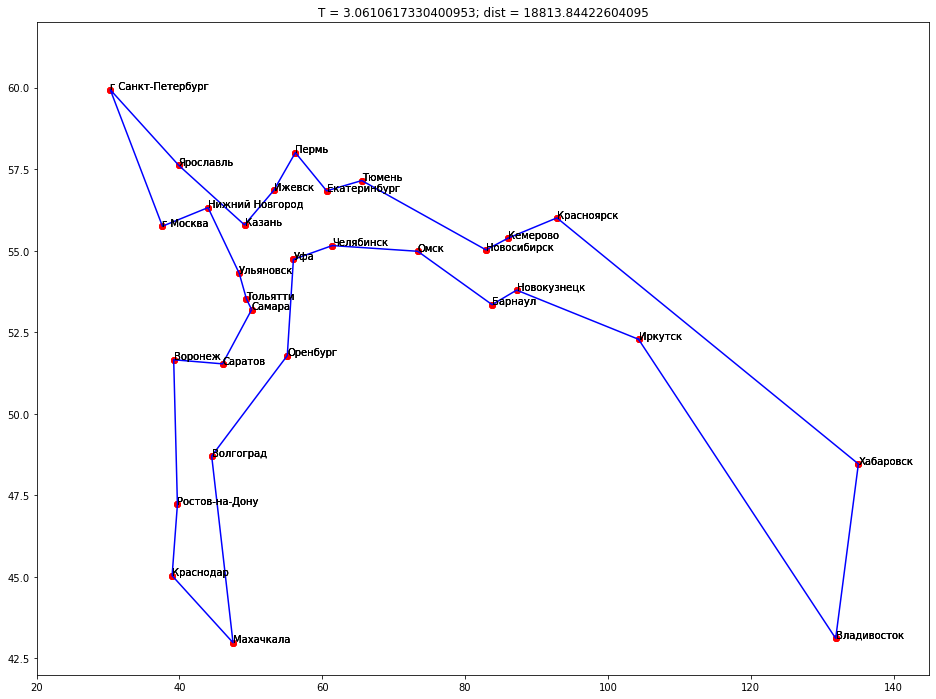

In [ ]:
from IPython.display import HTML, Image 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')


fig, ax = plt.subplots(figsize=(16, 12))
ln, = plt.plot([], [], color="blue")

def init():
    x = list(map(lambda x:x["geo_lon"], data))
    y = list(map(lambda x:x["geo_lat"], data))
    names = list(map(lambda x:x["city"], data))
    ax.set_xlim(20, 145)
    ax.set_ylim(42, 62)
    ax.scatter(x, y, color="r")
    for i, txt in enumerate(names):
        ax.annotate(f"{txt}", (x[i], y[i]))

def update(frame):
    T, cities, d = frame
    path = create_path(cities)
    x = list(map(lambda x:x["geo_lon"], path))
    y = list(map(lambda x:x["geo_lat"], path))
    ln.set_data(x, y)
    ax.set_title(f"T = {T}; dist = {d}")

frames = list(zip(history[0], history[1], history[2]))
ani = FuncAnimation(fig, update, frames=frames,
                    init_func=init, blit=False, interval=30)


ani.save('animation.gif', writer='pillow', fps=60)
result = HTML(ani.to_html5_video())

In [ ]:
result